Performs Lasso Regression on Dummified data set to do feature selection on coefficients 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [39]:
data_train = pd.read_csv('RowFiltered_dummied_data_TRAIN.csv')
data_test = pd.read_csv('RowFiltered_dummied_data_TEST.csv')


In [40]:
# list(data_train.columns)

In [41]:
data_train.head()

,SalePrice,Dist_From_UoI,GrLivArea,1stFlrSF,2ndFlrSF,TotRmsAbvGrd,BedroomAbvGr,FullBath,HalfBath,MSSubClass_>1-story,...,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_Timber,UnpavedDrive,WoodDeckBinary,HasPorch,FenceBinary,Fireplaces,NoCentralAir,SchD_S
0,179200,3.587525,1294,1294,0,6,3,2,0,0,...,1,0,0,0,1,1,1,0,0,0
1,115000,3.084359,1540,1040,500,7,4,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,110000,2.937397,892,892,0,5,3,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,131750,1.868841,960,960,0,4,2,1,0,0,...,0,0,0,0,1,1,0,0,0,0
4,190000,3.337009,1969,1161,808,8,3,2,1,1,...,0,0,0,0,0,1,0,1,0,0


In [42]:
#split y col 
data_testx=data_test.iloc[:,1:]
data_testy=data_test.iloc[:,0]
data_trainx=data_train.iloc[:,1:]
data_trainy=data_train.iloc[:,0]



In [68]:
#list(data_trainx.columns)

In [45]:
#standardize test and train
nonbinarycols=['Dist_From_UoI',
 'GrLivArea',
 '1stFlrSF',
 '2ndFlrSF',
 'TotRmsAbvGrd',
 'BedroomAbvGr',
 'FullBath',
 'HalfBath',
 
 'LotArea',
 'LndAc_S',

 'YearBuilt',
 'OverallQual',
 
 
 'RemodelYrsAftBuilt',
 
 'TotalBsmtSF',
 'BsmtUnfSF',
 
 'BsmtHalfBath',
 'BsmtFullBath',

 
 'GarageArea',
 'GarageCars',
 
 'Fireplaces'
 ]


In [46]:
scaler=StandardScaler()
scaler.fit(data_trainx[nonbinarycols])
data_trainx[nonbinarycols]=scaler.transform(data_trainx[nonbinarycols])
scaler.fit(data_testx[nonbinarycols])
data_testx[nonbinarycols]=scaler.transform(data_testx[nonbinarycols])

## CV Lasso regular data 

In [70]:
#CV LASSO FOR REG DATA
cvlasso=LassoCV( alphas=np.linspace(.0000001,20,1000), fit_intercept=True, normalize=False,cv=5)
cvlasso.fit(data_trainx,data_trainy)

lasso=Lasso(alpha=cvlasso.alpha_, fit_intercept=True, normalize=False)

print(f'The selected alpha was {cvlasso.alpha_} which gave r^2 of ')
print(cross_val_score(lasso, data_trainx,data_trainy,  scoring='r2'))

stdev = np.sqrt(sum((cvlasso.predict(data_trainx) - data_trainy)**2) / (len(data_trainy) - 2))
#prediction - 1.96*stdev, prediction + 1.96*stdev
#feel these are inflated bc alpha is trained on some of the later validating points

/Users/gabbyklein/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166225283976.1438, tolerance: 573435406.4634724
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gabbyklein/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 672675901.3337402, tolerance: 552358256.6715727
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gabbyklein/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161568838516.81497, tolerance: 552358256.6715727
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gabbyklein/opt/anaconda3/lib/python

The selected alpha was 20.0 which gave r^2 of 
[0.93639875 0.92913005 0.898829   0.93872975 0.91795361]


/Users/gabbyklein/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 672675901.5693359, tolerance: 552358256.6715727
  model = cd_fast.enet_coordinate_descent(


In [71]:
#actual test error 
cvlasso.score(data_testx,data_testy)

0.9306900169338181

In [72]:
#find mse for predictions in the .9-1.1 times the predicted price range

def mseprediction(pred, allpredictions, data_trainy):
    try:
        return mean_squared_error(data_trainy[(allpredictions<=pred*1.1) & (allpredictions>=pred*.9)],allpredictions[(allpredictions<=pred*1.1) & (allpredictions>=pred*.9)])**.5
    except:
        try:
            return mean_squared_error(data_trainy[(allpredictions<=pred*1.2) & (allpredictions>=pred*.8)],allpredictions[(allpredictions<=pred*1.1) & (allpredictions>=pred*.9)])**.5
        except:
            return 0


In [73]:
#assuming constant variance of ys 

predictiondf=pd.DataFrame({'Prediction': cvlasso.predict(data_testx), 'Lower Bound 95%CI': cvlasso.predict(data_testx)- 1.96*stdev,'Upper Bound 95%CI':cvlasso.predict(data_testx)+ 1.96*stdev})
actualpredictions=cvlasso.predict(data_trainx)
# finding avrg mse for prediction in +-10% price range
avrgmseperpredict=predictiondf.Prediction.apply(lambda x: mseprediction(x, actualpredictions, data_trainy))


In [74]:
predictiondf=pd.DataFrame({'Prediction': cvlasso.predict(data_testx),'Lower Bound Avrg MSE':-avrgmseperpredict+ cvlasso.predict(data_testx),'Upper Bound Avrg MSE':avrgmseperpredict+ cvlasso.predict(data_testx),'Lower Bound 95%CI': cvlasso.predict(data_testx)- 1.96*stdev,'Upper Bound 95%CI':cvlasso.predict(data_testx)+ 1.96*stdev})
predictiondf




,Prediction,Lower Bound Avrg MSE,Upper Bound Avrg MSE,Lower Bound 95%CI,Upper Bound 95%CI
0,226042.984671,206402.351431,245683.617912,192649.506551,259436.462792
1,211155.501928,192780.208793,229530.795062,177762.023807,244548.980048
2,345734.837276,321007.491612,370462.182941,312341.359156,379128.315397
3,170381.961686,155973.285248,184790.638125,136988.483566,203775.439807
4,164003.968057,149357.540583,178650.395530,130610.489936,197397.446177
...,...,...,...,...,...
728,122518.856497,110800.692735,134237.020259,89125.378377,155912.334618
729,149648.551741,136368.070528,162929.032954,116255.073620,183042.029862
730,105410.061557,93802.696184,117017.426931,72016.583437,138803.539678
731,103810.084497,91878.949896,115741.219098,70416.606376,137203.562617


In [52]:
#get that df with prediction and ci for one instance
def makeaprediction(xvars,model,data_trainx,data_trainy):
    stdev=np.sqrt(sum((model.predict(data_trainx) - data_trainy)**2) / (len(data_trainy) - 2))
    actualpredictions=model.predict(data_trainx)
    avrgmseperpredict=mseprediction(model.predict(xvars), actualpredictions, data_trainy)
    return pd.DataFrame({'Prediction': model.predict(xvars),'Lower Bound Avrg MSE':-avrgmseperpredict+ model.predict(xvars),'Upper Bound Avrg MSE':avrgmseperpredict+ model.predict(xvars),'Lower Bound 95%CI': model.predict(xvars)- 1.96*stdev,'Upper Bound 95%CI':model.predict(xvars)+ 1.96*stdev})



In [53]:
reshapexinputs=pd.DataFrame([data_testx.loc[0,:]],columns=data_trainx.columns)
makeaprediction(reshapexinputs,cvlasso,data_trainx,data_trainy)

,Prediction,Lower Bound Avrg MSE,Upper Bound Avrg MSE,Lower Bound 95%CI,Upper Bound 95%CI
0,226042.984671,206402.351431,245683.617912,192649.506551,259436.462792


In [54]:
results=pd.DataFrame({'Attr':data_trainx.columns,'Coef':cvlasso.coef_})
results[results.Coef!=0].sort_values(by=['Coef'],key=abs)
Nonzerocoefs=results[results.Coef!=0].Attr
results[results.Coef!=0]

,Attr,Coef
0,Dist_From_UoI,1053.660311
1,GrLivArea,7972.249374
2,1stFlrSF,6065.822877
3,2ndFlrSF,10003.102815
4,TotRmsAbvGrd,-1012.118709
...,...,...
95,WoodDeckBinary,-1487.681599
96,HasPorch,-1953.041294
97,FenceBinary,1200.918027
98,Fireplaces,2364.888971


In [55]:
# csv of SalePrice lasso selected cols
data_trainx[Nonzerocoefs].to_csv(r'Lasso_Selected_Cols_TRAIN.csv', index=False)
data_testx[Nonzerocoefs].to_csv(r'Lasso_Selected_Cols_TEST.csv', index=False)

Text(0.5, 0, 'Actual')

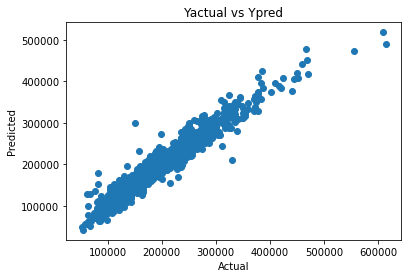

In [56]:
plt.scatter(data_trainy,cvlasso.predict(data_trainx) )
plt.title('Yactual vs Ypred')
plt.ylabel('Predicted')
plt.xlabel('Actual')

## Do it again on Log(SalePrice)

In [57]:
# create copy of train/test 
log_data_train = data_train.copy()
log_data_test = data_test.copy()

In [58]:
# log SalePrice and drop original column in test and train

log_data_train['log_SalePrice'] = np.log(log_data_train['SalePrice'])
log_data_train = log_data_train.drop(['SalePrice'], axis=1)
log_first_column = log_data_train.pop('log_SalePrice')
log_data_train.insert(0, 'log_SalePrice', log_first_column)

log_data_test['log_SalePrice'] = np.log(log_data_test['SalePrice'])
log_data_test = log_data_test.drop(['SalePrice'], axis=1)
log_first_columnt = log_data_test.pop('log_SalePrice')
log_data_test.insert(0, 'log_SalePrice', log_first_columnt)

In [59]:
log_data_testx=data_testx.copy()
log_data_testy=log_data_test.iloc[:,0]
log_data_trainx=data_trainx.copy()
log_data_trainy=log_data_train.iloc[:,0]

In [60]:
scaler.fit(log_data_trainx[nonbinarycols])
log_data_trainx[nonbinarycols]=scaler.transform(log_data_trainx[nonbinarycols])
scaler.fit(log_data_testx[nonbinarycols])
log_data_testx[nonbinarycols]=scaler.transform(log_data_testx[nonbinarycols])

In [61]:
#CV LASSO FOR LOG DATA
cvlasso=LassoCV( alphas=np.linspace(.00000000000001,5,1000), fit_intercept=True, normalize=False,cv=5)
cvlasso.fit(log_data_trainx,log_data_trainy)

lasso=Lasso(alpha=cvlasso.alpha_, fit_intercept=True, normalize=False)
print(f'The selected alpha was {cvlasso.alpha_} which gave r^2 of ')
print(cross_val_score(lasso, log_data_trainx,log_data_trainy,  scoring='r2'))

stdev = np.sqrt(sum((cvlasso.predict(log_data_trainx) - log_data_trainy)**2) / (len(log_data_trainy) - 2))
#prediction - 1.96*stdev, prediction + 1.96*stdev
#feel these are inflated bc alpha is trained on some of the later validating points

/Users/gabbyklein/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.441545918506496, tolerance: 0.015444101267082318
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gabbyklein/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.926946582216556, tolerance: 0.015357777410073806
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gabbyklein/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.511471473172417, tolerance: 0.015827686153756786
  model = cd_fast.enet_coordinate_descent_gram(
/Users/gabbyklein/opt/anaconda3/li

The selected alpha was 1e-14 which gave r^2 of 
[0.91097016 0.94017345 0.90441913 0.93573005 0.92151743]


/Users/gabbyklein/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.511471462836842, tolerance: 0.015827686153756786
  model = cd_fast.enet_coordinate_descent(
/Users/gabbyklein/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.75371843541089, tolerance: 0.014919602202474937
  model = cd_fast.enet_coordinate_descent(
/Users/gabbyklein/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.486264623424668, tolerance: 0.015136913983794853
  model = cd_fast.enet_coordinate_descent(


In [62]:
#actual test error 
cvlasso.score(log_data_testx,log_data_testy)

0.9278727537467196

In [63]:
results=pd.DataFrame({'Attr':log_data_trainx.columns,'Coef':cvlasso.coef_})
results[results.Coef!=0].sort_values(by=['Coef'],key=abs)
Nonzerocoefs=results[results.Coef!=0].Attr
results[results.Coef!=0]

,Attr,Coef
0,Dist_From_UoI,-0.017250
1,GrLivArea,0.053919
2,1stFlrSF,0.040042
3,2ndFlrSF,0.056711
4,TotRmsAbvGrd,-0.006007
...,...,...
96,HasPorch,0.002760
97,FenceBinary,0.004997
98,Fireplaces,0.009961
99,NoCentralAir,-0.054246


In [64]:
# csv of SalePrice log_lasso selected cols
log_data_trainx[Nonzerocoefs].to_csv(r'log_Lasso_Selected_Cols_TRAIN.csv', index=False)
log_data_testx[Nonzerocoefs].to_csv(r'log_Lasso_Selected_Cols_TEST.csv', index=False)

Text(0.5, 0, 'Actual')

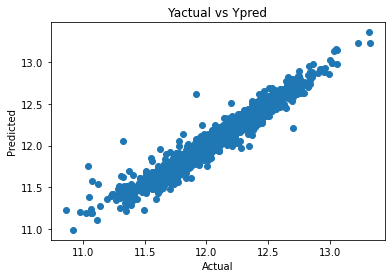

In [65]:
plt.scatter(log_data_trainy,cvlasso.predict(log_data_trainx) )

plt.title('Yactual vs Ypred')
plt.ylabel('Predicted')
plt.xlabel('Actual')

In [66]:
stdev = np.sqrt(sum((cvlasso.predict(log_data_trainx) - log_data_trainy)**2) / (len(log_data_trainy) - 2))
predictiondf=pd.DataFrame({'Prediction': cvlasso.predict(log_data_testx), 'Lower Bound 95%CI': cvlasso.predict(log_data_testx)- 1.96*stdev,'Upper Bound 95%CI':cvlasso.predict(log_data_testx)+ 1.96*stdev})

actualpredictions=cvlasso.predict(log_data_trainx)
# finding avrg mse for prediction in +-10% price range
avrgmseperpredict=predictiondf.Prediction.apply(lambda x: mseprediction(x, actualpredictions, log_data_trainy))



In [67]:
predictiondf=pd.DataFrame({'Prediction': cvlasso.predict(log_data_testx),'Lower Bound Avrg MSE':-avrgmseperpredict+ cvlasso.predict(log_data_testx),'Upper Bound Avrg MSE':avrgmseperpredict+ cvlasso.predict(log_data_testx),'Lower Bound 95%CI': cvlasso.predict(log_data_testx)- 1.96*stdev,'Upper Bound 95%CI':cvlasso.predict(log_data_testx)+ 1.96*stdev})

predictiondf


,Prediction,Lower Bound Avrg MSE,Upper Bound Avrg MSE,Lower Bound 95%CI,Upper Bound 95%CI
0,12.316095,12.226807,12.405384,12.140990,12.491200
1,12.119969,12.030666,12.209273,11.944865,12.295074
2,12.865489,12.779680,12.951298,12.690384,13.040593
3,12.071953,11.982650,12.161257,11.896849,12.247058
4,12.009416,11.920094,12.098738,11.834311,12.184520
...,...,...,...,...,...
728,11.760377,11.671031,11.849724,11.585273,11.935482
729,11.878997,11.789697,11.968298,11.703893,12.054102
730,11.534551,11.444890,11.624211,11.359446,11.709655
731,11.571811,11.482209,11.661413,11.396707,11.746916


## Lasso on Rs selected cols

In [69]:
rcols=["MasVnrType_BrkFace" ,  "Foundation_Stone" ,    "Exterior1st_AsbShng" , "LotArea"             
 , "Fireplaces"    ,       "HeatingQC_TA"     ,    "Exterior1st_BrkFace",  "Foundation_Wood"     
 , "Condition1_Artery" ,   "BsmtFinGdLvng"    ,    "Functional_Min" ,      "Neighborhood_NoRidge"
,"ExterQual_Gd"     ,    "BsmtExposure"       ,  "KitchenQual_Ex"  ,     "BsmtQual_Ex"         
,"Functional_Maj"    ,   "OverallCondBinary"  ,  "OverallQual"  ,        "ExterQual_Ex"        
,"TotalBsmtSF"   ,       "BsmtUnfSF"         ,   "GrLivArea"      ,      "LndAc_S" ]
data_trainxsubsetR=data_trainx[rcols]
data_testxsubsetR=data_testx[rcols]
lasso.set_params(alpha=0)
lasso.fit(data_trainxsubsetR, data_trainy) 
(lasso.score(data_trainxsubsetR, data_trainy))
(lasso.score(data_testxsubsetR, data_testy))

<ipython-input-69-06b3a9c555bc>:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(data_trainxsubsetR, data_trainy)
/Users/gabbyklein/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/gabbyklein/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 242194956750.70377, tolerance: 718014430.4529438
  model = cd_fast.enet_coordinate_descent(


0.9263185801244276

In [38]:
stdev = np.sqrt(sum((lasso.predict(data_trainxsubsetR) - data_trainy)**2) / (len(data_trainy) - 2))
predictiondf=pd.DataFrame({'Prediction': lasso.predict(data_testxsubsetR), 'Lower Bound 95%CI': lasso.predict(data_testxsubsetR)- 1.96*stdev,'Upper Bound 95%CI':lasso.predict(data_testxsubsetR)+ 1.96*stdev})

actualpredictions=lasso.predict(data_trainxsubsetR)
# finding avrg mse for prediction in +-10% price range
avrgmseperpredict=predictiondf.Prediction.apply(lambda x: mseprediction(x, actualpredictions, data_trainy))

predictiondf=pd.DataFrame({'Prediction': lasso.predict(data_testxsubsetR),'Lower Bound Avrg MSE':-avrgmseperpredict+ lasso.predict(data_testxsubsetR),'Upper Bound Avrg MSE':avrgmseperpredict+ lasso.predict(data_testxsubsetR),'Lower Bound 95%CI': lasso.predict(data_testxsubsetR)- 1.96*stdev,'Upper Bound 95%CI':lasso.predict(data_testxsubsetR)+ 1.96*stdev})

predictiondf




,Prediction,Lower Bound Avrg MSE,Upper Bound Avrg MSE,Lower Bound 95%CI,Upper Bound 95%CI
0,184309.285059,166235.193957,202383.376160,146981.385892,221637.184225
1,99041.798399,82747.133475,115336.463323,61713.899233,136369.697566
2,147320.847727,132906.633827,161735.061628,109992.948561,184648.746894
3,474512.155522,406208.080981,542816.230063,437184.256355,511840.054689
4,233961.230350,212964.612631,254957.848070,196633.331184,271289.129517
...,...,...,...,...,...
847,94210.793085,77622.605814,110798.980356,56882.893919,131538.692252
848,98800.174745,82535.340102,115065.009389,61472.275579,136128.073912
849,140156.412143,126155.747498,154157.076789,102828.512977,177484.311310
850,138329.659243,124252.033517,152407.284969,101001.760077,175657.558410


In [ ]:

# csv of R's ~23 cols
data_trainxsubsetR.to_csv(r'Stepwise_Selected_Cols_R_TRAIN.csv', index=False)
data_testxsubsetR.to_csv(r'Stepwise_Selected_Cols_R_TEST.csv', index=False)


# Lasso on Dummy Data

In [ ]:

# data_testx=data_test.iloc[:,1:]
# data_testy=data_test.iloc[:,0]
# data_trainx=data_train.iloc[:,1:]
# data_trainy=data_train.iloc[:,0]


In [ ]:
# #standardize non binary cats
# nonbinarycols=['GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'BedroomAbvGr',
#        'FullBath', 'HalfBath',  'LotArea',
#        'LndAc_S',   'MasVnrArea',
#         'YearBuilt',
#        'OverallQual', 'TotalBsmtSF', 'BsmtUnfSF',
#         'BsmtHalfBath', 'BsmtFullBath', 
#         'GarageArea', 'GarageCars',  'Fireplaces'
#         ]

In [ ]:
# #standardize non binary cols for lasso
# for i in (nonbinarycols):
#     data_trainx[i]=(data_trainx[i] - data_trainx[i].mean()) / data_trainx[i].std()    
    
# for i in (nonbinarycols):
#     data_testx[i]=(data_testx[i] - data_testx[i].mean()) / data_testx[i].std() 

In [ ]:
#data_testx.head()

In [ ]:
#lasso  = Lasso(normalize=True)

Broad view of the test and train R2 as penalization grows

In [ ]:
# lasso  = Lasso(normalize=True)
# alphas = np.linspace(0,2500,1000)
# lasso.set_params()
# coefs_lasso  = []
# trainr2=[]
# testr2=[]

# for alpha in alphas:
#         lasso.set_params(alpha=alpha)
#         lasso.fit(data_trainx, data_trainy) 
#         trainr2.append(lasso.score(data_trainx, data_trainy))
#         testr2.append(lasso.score(data_testx, data_testy))
#         coefs_lasso.append(lasso.coef_)
# coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = data_trainx.columns)  
# coefs_lasso.head()

  

In [ ]:
# plt.plot(alphas, trainr2, c='b', label=r'train $R^2$')
# plt.plot(alphas, testr2, c='r', label=r'test $R^2$')
# plt.legend(loc=1)
# plt.title(r'$R^2$ Drops with Increaing Regularizations')
# plt.xlabel(r'hyperparameter $\alpha$')
# plt.ylabel(r'$R^2$')

Zoomed in on where test and train r2 are maxed 

In [ ]:
# lasso  = Lasso(normalize=True)
# alphas = np.linspace(0,5,1000)
# lasso.set_params()
# coefs_lasso  = []
# trainr2=[]
# testr2=[]

# for alpha in alphas:
#         lasso.set_params(alpha=alpha)
#         lasso.fit(data_trainx, data_trainy) 
#         trainr2.append(lasso.score(data_trainx, data_trainy))
#         testr2.append(lasso.score(data_testx, data_testy))
#         coefs_lasso.append(lasso.coef_)
# coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = data_trainx.columns)  
# coefs_lasso.head()

  

In [ ]:

# #alpha which maximized the testr2
# maxind=testr2.index(max(testr2))
# bestalpha=alphas[maxind]
# bestalpha

In [ ]:
# plt.plot(alphas, trainr2, c='b', label=r'train $R^2$')
# plt.plot(alphas, testr2, c='r', label=r'test $R^2$')
# plt.axvline(x=bestalpha,label=r'Best Alpha on Test Data')
# plt.legend(loc=1)
# plt.title(r'$R^2$ Zoomed in')
# plt.xlabel(r'hyperparameter $\lambda$')
# plt.ylabel(r'$R^2$')



In [ ]:
# for name in coefs_lasso.columns:
#     plt.plot(coefs_lasso.index, coefs_lasso[name], label=name)
# plt.xlabel(r'hyperparameter $\lambda$')
# plt.ylabel(r'slope values')
## plt.legend(loc=1) 

In [ ]:
# sum(coefs_lasso.iloc[maxind]!=0)

In [ ]:
# #visualize number of coefs used per alpha

# num_nonzero_coef=[]
# for i in range(len(alphas)):
#     num_nonzero_coef.append(sum(coefs_lasso.iloc[i]!=0))

In [ ]:
# plt.plot(alphas, num_nonzero_coef, c='b')
# plt.legend(loc=1)
# plt.title(r'Alpha vs # Non Zero Coefs')
# plt.xlabel(r'Alpha')
# plt.ylabel(r'# non zero coefs')

In [ ]:
# plt.plot(num_nonzero_coef,testr2, c='b', label=r'test $R^2$')
# plt.legend(loc=1)
# plt.title(r'Alpha vs # Non Zero Coefs')
# plt.ylabel(r'$R^2$')
# plt.xlabel(r'# non zero coefs')

In [ ]:
# #Examining the best model

# lasso.set_params(alpha=bestalpha)
# lasso.fit(data_trainx, data_trainy)

# print('The train R2 is ',lasso.score(data_trainx, data_trainy))
# print('The test R2 is ',lasso.score(data_testx, data_testy))
# #pd.DataFrame(lasso.coef_,  columns = data_trainx.columns)
# columns = data_trainx.columns
# coeflist=list(zip(columns,lasso.coef_))
# coefdf=pd.DataFrame(coeflist, columns=['Attr','Coef'])
# coefdf=coefdf[coefdf.Coef!=0]
# coefdf.sort_values(by=['Coef'],key=abs)

# Lasso on Dummy Data w Log SalePrice

In [ ]:
# # create copy of train/test 
# log_data_train = data_train.copy()
# log_data_test = data_test.copy()

In [ ]:
# log_data_train

In [ ]:
# # log SalePrice and drop original column in test and train

# log_data_train['log_SalePrice'] = np.log(log_data_train['SalePrice'])
# log_data_train = log_data_train.drop(['SalePrice'], axis=1)
# log_first_column = log_data_train.pop('log_SalePrice')
# log_data_train.insert(0, 'log_SalePrice', log_first_column)

# log_data_test['log_SalePrice'] = np.log(log_data_test['SalePrice'])
# log_data_test = log_data_test.drop(['SalePrice'], axis=1)
# log_first_columnt = log_data_test.pop('log_SalePrice')
# log_data_test.insert(0, 'log_SalePrice', log_first_columnt)

In [ ]:
# log_data_testx=data_testx.copy()
# log_data_testy=log_data_test.iloc[:,0]
# log_data_trainx=data_trainx.copy()
# log_data_trainy=log_data_train.iloc[:,0]

In [ ]:
# log_data_testx.head()

In [ ]:
# log_data_testy.head()

In [ ]:
# log_lasso  = Lasso(normalize=True)
# log_alphas = np.linspace(0, 0.02, 1000)
# log_lasso.set_params()
# log_coefs_lasso  = []
# log_trainr2=[]
# log_testr2=[]

# for log_alpha in log_alphas:
#         log_lasso.set_params(alpha=log_alpha)
#         log_lasso.fit(log_data_trainx, log_data_trainy) 
#         log_trainr2.append(log_lasso.score(log_data_trainx, log_data_trainy))
#         log_testr2.append(log_lasso.score(log_data_testx, log_data_testy))
#         log_coefs_lasso.append(log_lasso.coef_)
# log_coefs_lasso = pd.DataFrame(log_coefs_lasso, index = log_alphas, columns = log_data_trainx.columns)  
# log_coefs_lasso.head()

In [ ]:
# plt.plot(log_alphas, log_trainr2, c='b', label=r'log_train $R^2$')
# plt.plot(log_alphas, log_testr2, c='r', label=r'log_test $R^2$')
# plt.legend(loc=1)
# plt.title(r'$R^2$ Drops with Increaing Regularizations')
# plt.xlabel(r'hyperparameter $\lambda$')
# plt.ylabel(r'$R^2$')

In [ ]:
#alpha which maximized the log_testr2
# log_maxind=log_testr2.index(max(log_testr2))
# log_bestalpha=log_alphas[log_maxind]
# log_bestalpha

In [ ]:
# plt.plot(log_alphas, log_trainr2, c='b', label=r'log_train $R^2$')
# plt.plot(log_alphas, log_testr2, c='r', label=r'log_test $R^2$')
# plt.axvline(x=log_bestalpha,label=r'Best Alpha on log_Test Data')
# plt.legend(loc=1)
# plt.title(r'$R^2$ Zoomed in')
# plt.xlabel(r'hyperparameter $\lambda$')
# plt.ylabel(r'$R^2$')

In [ ]:
# sum(log_coefs_lasso.iloc[log_maxind]!=0)

In [ ]:
#visualize number of coefs used per log_alpha

# log_num_nonzero_coef=[]
# for i in range(len(log_alphas)):
#     log_num_nonzero_coef.append(sum(log_coefs_lasso.iloc[i]!=0))

In [ ]:
# plt.plot(log_alphas, log_num_nonzero_coef, c='b')
# plt.legend(loc=1)
# plt.title(r'log_Alpha vs # Non Zero Coefs')
# plt.xlabel(r'log_Alpha')
# plt.ylabel(r'# non zero coefs')

In [ ]:
# plt.plot(log_num_nonzero_coef,log_testr2, c='b', label=r'test $R^2$')
# plt.legend(loc=1)
# plt.title(r'log_Alpha vs # Non Zero Coefs')
# plt.ylabel(r'$R^2$')
# plt.xlabel(r'# non zero coefs')

In [ ]:
#Examining the best model

# log_lasso.set_params(alpha=log_bestalpha)
# log_lasso.fit(log_data_trainx, log_data_trainy)

# print('The log_train R2 is ',log_lasso.score(log_data_trainx, log_data_trainy))
# print('The log_test R2 is ',log_lasso.score(log_data_testx, log_data_testy))
# #pd.DataFrame(lasso.coef_,  columns = data_trainx.columns)
# log_columns = log_data_trainx.columns
# log_coeflist=list(zip(log_columns,log_lasso.coef_))
# log_coefdf=pd.DataFrame(log_coeflist, columns=['Attr','Coef'])
# log_coefdf=log_coefdf[log_coefdf.Coef!=0]
# log_coefdf.sort_values(by=['Coef'],key=abs)

# Lasso on Dummy Data w Price per sqaure ft

In [ ]:
# # create new copy of train/test
# sq_data_train = data_train.copy()
# sq_data_test = data_test.copy()

In [ ]:
# sq_data_train

In [ ]:
# # price per square feet = saleprice/grlivarea
# sq_data_train['Price_per_sq'] = sq_data_train['SalePrice']/sq_data_train['GrLivArea']
# sq_data_train = sq_data_train.drop(['SalePrice', 'GrLivArea'], axis=1)
# sq_first_column = sq_data_train.pop('Price_per_sq')
# sq_data_train.insert(0, 'Price_per_sq', sq_first_column)

# sq_data_test['Price_per_sq'] = sq_data_test['SalePrice']/sq_data_test['GrLivArea']
# sq_data_test = sq_data_test.drop(['SalePrice', 'GrLivArea'], axis=1)
# sq_first_columnt = sq_data_test.pop('Price_per_sq')
# sq_data_test.insert(0, 'Price_per_sq', sq_first_columnt)

In [ ]:
# sq_data_testx = sq_data_test.iloc[:,1:]
# sq_data_testy = sq_data_test.iloc[:,0]
# sq_data_trainx = sq_data_train.iloc[:,1:]
# sq_data_trainy = sq_data_train.iloc[:,0]

In [ ]:
# sq_nonbinarycols = ['1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'BedroomAbvGr',
#        'FullBath', 'HalfBath',  'LotArea',
#        'LndAc_S',   'MasVnrArea',
#         'YearBuilt',
#        'OverallQual', 'TotalBsmtSF', 'BsmtUnfSF',
#         'BsmtHalfBath', 'BsmtFullBath', 
#         'GarageArea', 'GarageCars',  'Fireplaces'
#         ]
# sq_nonbinarycols

In [ ]:
# #standardize non binary cols for sq_lasso

# for i in (sq_nonbinarycols):
#     sq_data_trainx[i]=(sq_data_trainx[i] - sq_data_trainx[i].mean()) / sq_data_trainx[i].std()    
    
# for i in (sq_nonbinarycols):
#     sq_data_testx[i]=(sq_data_testx[i] - sq_data_testx[i].mean()) / sq_data_testx[i].std()

In [ ]:
# sq_data_testx.head()

In [ ]:
# sq_data_testy.head()

In [ ]:
# sq_lasso  = Lasso(normalize=True)
# sq_alphas = np.linspace(0, .6, 1000)
# sq_lasso.set_params()
# sq_coefs_lasso  = []
# sq_trainr2=[]
# sq_testr2=[]

# for sq_alpha in sq_alphas:
#         sq_lasso.set_params(alpha=sq_alpha)
#         sq_lasso.fit(sq_data_trainx, sq_data_trainy) 
#         sq_trainr2.append(sq_lasso.score(sq_data_trainx, sq_data_trainy))
#         sq_testr2.append(sq_lasso.score(sq_data_testx, sq_data_testy))
#         sq_coefs_lasso.append(sq_lasso.coef_)
# sq_coefs_lasso = pd.DataFrame(sq_coefs_lasso, index = sq_alphas, columns = sq_data_trainx.columns)  
# sq_coefs_lasso.head()

In [ ]:
# plt.plot(sq_alphas, sq_trainr2, c='b', label=r'sq_train $R^2$')
# plt.plot(sq_alphas, sq_testr2, c='r', label=r'sq_test $R^2$')
# plt.legend(loc=1)
# plt.title(r'$R^2$ Drops with Increaing Regularizations')
# plt.xlabel(r'hyperparameter $\lambda$')
# plt.ylabel(r'$R^2$')

In [ ]:
# #sq_alpha which maximized the sq_testr2
# sq_maxind=sq_testr2.index(max(sq_testr2))
# sq_bestalpha=sq_alphas[sq_maxind]
# sq_bestalpha

In [ ]:
# plt.plot(sq_alphas, sq_trainr2, c='b', label=r'sq_train $R^2$')
# plt.plot(sq_alphas, sq_testr2, c='r', label=r'sq_test $R^2$')
# plt.axvline(x=sq_bestalpha,label=r'Best Alpha on sq_Test Data')
# plt.legend(loc=1)
# plt.title(r'$R^2$ Zoomed in')
# plt.xlabel(r'hyperparameter $\lambda$')
# plt.ylabel(r'$R^2$')

In [ ]:
# sum(sq_coefs_lasso.iloc[sq_maxind]!=0)

In [ ]:
# #visualize number of coefs used per sq_alpha

# sq_num_nonzero_coef=[]
# for i in range(len(sq_alphas)):
#     sq_num_nonzero_coef.append(sum(sq_coefs_lasso.iloc[i]!=0))

In [ ]:
# plt.plot(sq_alphas, sq_num_nonzero_coef, c='b')
# plt.legend(loc=1)
# plt.title(r'log_Alpha vs # Non Zero Coefs')
# plt.xlabel(r'sq_Alpha')
# plt.ylabel(r'# non zero coefs')

In [ ]:
# plt.plot(sq_num_nonzero_coef,sq_testr2, c='b', label=r'sq_test $R^2$')
# plt.legend(loc=1)
# plt.title(r'sq_Alpha vs # Non Zero Coefs')
# plt.ylabel(r'$R^2$')
# plt.xlabel(r'# non zero coefs')

In [ ]:
# #Examining the best model

# sq_lasso.set_params(alpha=sq_bestalpha)
# sq_lasso.fit(sq_data_trainx, sq_data_trainy)

# print('The sq_train R2 is ',sq_lasso.score(sq_data_trainx, sq_data_trainy))
# print('The sq_test R2 is ',sq_lasso.score(sq_data_testx, sq_data_testy))
# #pd.DataFrame(lasso.coef_,  columns = data_trainx.columns)
# sq_columns = sq_data_trainx.columns
# sq_coeflist=list(zip(sq_columns,sq_lasso.coef_))
# sq_coefdf=pd.DataFrame(sq_coeflist, columns=['Attr','Coef'])
# sq_coefdf=sq_coefdf[sq_coefdf.Coef!=0]
# sq_coefdf.sort_values(by=['Coef'],key=abs)

## R's stepwise features regression

In [ ]:
# data_trainxsubsetR=data_trainx[['LotConfig_CulDSac','ExterQual_Gd','Neighborhood_IDOTRR','Condition1_Artery','BsmtQual_Gd','HeatingQC_TA','MSSubClass_multi_fam','BsmtFinGdLvng','BedroomAbvGr','Neighborhood_NoRidge','RemodelYrsAftBuilt', 'MasVnrType_BrkFace','BldgType_TwnhsE' ,'MasVnrArea','Functional_Min','BldgType_Twnhs','Functional_Maj','BsmtQual_Ex'         ,'BsmtExposure' ,'Exterior1st_BrkFace','OverallCondBinary','YearBuilt','TotalBsmtSF','BsmtUnfSF','ExterQual_Ex','OverallQual','GrLivArea','LndAc_S']]
# data_testxsubsetR=data_testx[['LotConfig_CulDSac','ExterQual_Gd','Neighborhood_IDOTRR','Condition1_Artery','BsmtQual_Gd','HeatingQC_TA','MSSubClass_multi_fam','BsmtFinGdLvng','BedroomAbvGr','Neighborhood_NoRidge','RemodelYrsAftBuilt', 'MasVnrType_BrkFace','BldgType_TwnhsE' ,'MasVnrArea','Functional_Min','BldgType_Twnhs','Functional_Maj','BsmtQual_Ex'         ,'BsmtExposure' ,'Exterior1st_BrkFace','OverallCondBinary','YearBuilt','TotalBsmtSF','BsmtUnfSF','ExterQual_Ex','OverallQual','GrLivArea','LndAc_S']]

# lasso.set_params(alpha=0)
# lasso.fit(data_trainxsubsetR, data_trainy) 
# (lasso.score(data_trainxsubsetR, data_trainy))
# (lasso.score(data_testxsubsetR, data_testy))

## Generate CSVs with subset of cols 
-didnt know which we wanted to play w so comment/uncomment as you please

In [ ]:

# # # R's ~23 cols
# # data_trainxsubsetR.to_csv(r'Stepwise_Selected_Cols_R_TRAIN.csv', index=False)
# # data_testxsubsetR.to_csv(r'Stepwise_Selected_Cols_R_TEST.csv', index=False)
# # #Log(SalePrice) lasso selected cols
# # log_data_trainx.to_csv(r'Lasso_Selected_Cols_LOG_TRAIN.csv', index=False)
# # log_data_testx.to_csv(r'Lasso_Selected_Cols_LOG_TEST.csv', index=False)
# # #SalePrice lasso selected cols
# # data_trainx.to_csv(r'Lasso_Selected_Cols_TRAIN.csv', index=False)
# #data_testx.to_csv(r'Lasso_Selected_Cols_TEST.csv', index=False)

In [ ]:
#def lassoalphatune(xtrain,ytrain,alpharange):
    
    